In [ ]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity,energy
import jax_md
from jax_md import energy, partition
from jax_pd import space, materials, damage, mesh, plots, solvers, util, simulation


In [112]:
displacement_fn, shift_fn = space.free()

R_1 = onp.array([[i,j,k] for i in range(10) for j in range(2,4) for k in range(2)],dtype=np.float32)
R_2 = onp.array([[i,j,k] for i in range(10) for j in range(35,37) for k in range(2)],dtype=np.float32)
R_3 = onp.array([[i,j,k] for i in range(4,6) for j in range(40) for k in range(3,5)],dtype=np.float32)

R = onp.vstack([R_1,R_2,R_3])

R = np.array(R)

box_size = [20,20,20]
cutoff = f32(2.5)

bonds0 = util.bonds(displacement_fn, box_size, cutoff, R)



In [113]:
lengths0 = util.bond_lengths(bonds0,R)
bonds0.shape


(2419, 2)

In [114]:
stretch = f32(0.4)
epsilon = f32(100)
epsilon2 = f32(1000)
radius = f32(1)

energy_fn = [{'func':materials.simple_spring_bond,
              'args':[displacement_fn], 
              'kwargs':dict(bond=bonds0,length=lengths0, epsilon=epsilon, stretch=stretch, 
                            radius=radius, epsilon2=epsilon2)
                 }, 
            {'func':energy.soft_sphere_pair, 
             'args':[displacement_fn], 
             'kwargs':dict(sigma=radius, epsilon=epsilon2)
                },
                [bonds0,stretch]]

def cal_energy(R,energy_fn):
    energy_fn_calable = [i['func'](*i['args'],**i['kwargs']) for i in energy_fn[:-1]]
    return np.sum([j(R) for j in energy_fn_calable])

cal_energy(R,energy_fn)

DeviceArray(0., dtype=float32)

In [115]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


iVbc = [{'bool':(R[:,2]<2),'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,-5]])}}]

iVbc += [{'bool':(R[:,2]>2),'fn':move,'kwargs':{'R0':R*0-np.array([[0,0,5]])}},
       ]


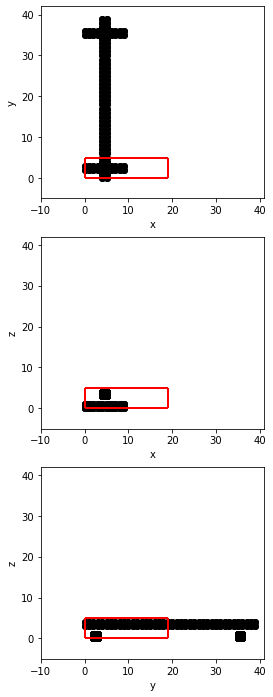

In [116]:
R1 = [R]

def myplot(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    ls = []
    ms = 5
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ls.append(ax.plot([],[],'o', markersize=ms)[0])
        ax.set_xlim([-10, 41])
        ax.set_ylim([-5, 42])
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs,color='k')
    plt.show()

myplot(0)


In [117]:
runs = 500

info = [[],[],[]]
simulation.run(info,key,runs,1.0e-2, R,energy_fn,shift_fn,iVbc=iVbc,mass=1.0,print_every=20,value_every=20,pos_every=1)


Initial conditions(after iBC): 
KE: 3000.000000, PE: 0.000, TE: 3000.000
Initial conditions(after BC): 
KE: 3000.000000, PE: 0.000, TE: 3000.000
Run # 0 :  KE: 2941.230713, PE: 61.255, TE: 3002.486
Run # 20 :  KE: 2071.812500, PE: 927.140, TE: 2998.952
Run # 40 :  KE: 2005.474609, PE: 986.423, TE: 2991.898
Run # 60 :  KE: 1811.893555, PE: 1173.131, TE: 2985.025
Run # 80 :  KE: 1707.278809, PE: 1262.558, TE: 2969.836
Run # 100 :  KE: 1767.296875, PE: 1203.176, TE: 2970.472
Run # 120 :  KE: 1747.075195, PE: 1222.982, TE: 2970.057
Run # 140 :  KE: 1391.557373, PE: 1578.300, TE: 2969.857
Run # 160 :  KE: 1218.183472, PE: 1752.073, TE: 2970.257
Run # 180 :  KE: 1391.786865, PE: 1578.837, TE: 2970.624
Run # 200 :  KE: 1524.303345, PE: 1446.251, TE: 2970.555
Run # 220 :  KE: 1663.043823, PE: 1298.125, TE: 2961.168
Run # 240 :  KE: 1461.645630, PE: 1500.876, TE: 2962.522
Run # 260 :  KE: 1336.413452, PE: 1619.896, TE: 2956.310
Run # 280 :  KE: 1438.243530, PE: 1494.278, TE: 2932.521
Run # 300 

True

In [118]:
R1, S1, state_values = info

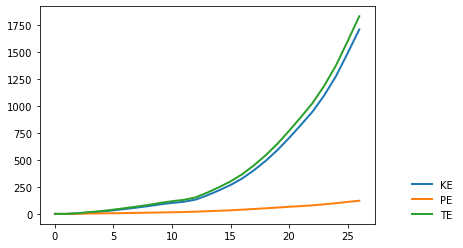

In [87]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])

In [88]:
F1 = []
F2 = []

mask1 = R[:,0]>4
F1 += [(state.acceleration[mask1,0]*state.mass).sum() for state in S1]
    

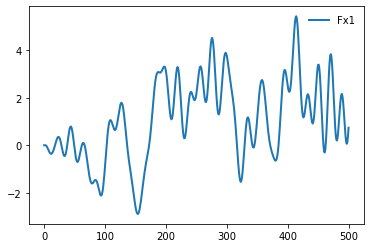

In [89]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.legend(frameon=0)

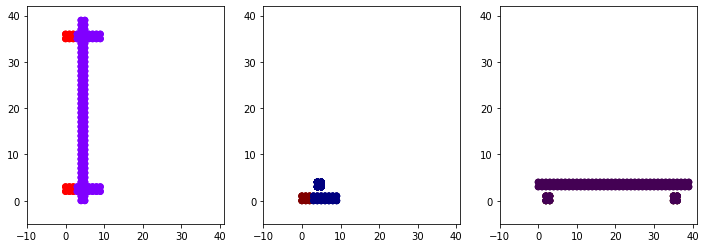

In [120]:
import matplotlib
k = 10
ms = 5

def myplot(i):
    global axs,l,k
    i = i*k
    R_plt = onp.array(R1[i])
    for ax in axs:
        ax.clear()
        ax.set_xlim([-10, 41])
        ax.set_ylim([-5, 42])

    axs[0].scatter(R_plt[:, 0], R_plt[:, 1]) 
    axs[1].scatter(R_plt[:, 0], R_plt[:, 2]) 
    axs[2].scatter(R_plt[:, 1], R_plt[:, 2]) 

    

fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ax.set_xlim([-10, 21])
    ax.set_ylim([-5, 22])
    ax.axis('on')


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(R1)/k))

from IPython.display import HTML
HTML(ani.to_jshtml())


In [119]:
print(len(R1))
with open('./datafile-bar.xyz','w+') as f:
    for r in R1:
        f.write(str(len(r))+'\n\n')        
        for i,t in zip(r,mask):
            f.write('{} {} {} {}\n'.format(*i,t))
            

501
